In [ ]:
!pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from tqdm import tqdm
from faker import Faker
import numpy as np

# Setup
fake = Faker()
Faker.seed(4321)
np.random.seed(12345)
sampsize = 10000  # Total sample size

# Generate IDs and initial data
IDlist = np.random.randint(0, high=sampsize, size=sampsize)
rngbet_preexp = np.random.beta(2, 1, sampsize)  # Moderate variability in the control
rngbet_exp = np.random.beta(2.5, 1, sampsize)  # Slightly higher variability in treatment

def generate_dataset(sampsize):
    data = pd.DataFrame()
    for i in tqdm(range(sampsize), desc='Creating DataFrame'):
        # Assign basic information
        data.loc[i, 'ride ID'] = IDlist[i]
        data.loc[i, 'rider name'] = fake.name()
        data.loc[i, 'driver ID'] = np.random.randint(1, 5000)

        # Determine the period and adjust ride details
        if i < sampsize * 1/4:  # Pre-experiment period (control and treatment)
            period = 'pre-ctrl' if np.random.rand() > 0.5 else 'pre-trt'
            ride_duration = np.random.randint(5, 31)
            beta = rngbet_preexp[i]
            wait_time = np.random.randint(1, 12)  # Moderately short wait times
        elif i < sampsize * 7/8:  # During experiment, promotional 'yes'
            period = 'yes'
            ride_duration = np.random.randint(5, 31)
            beta = rngbet_exp[i]  # Promotional beta factor
            wait_time = np.random.randint(5, 25)  # Gradually longer wait times
        else:  # During experiment, promotional 'no'
            period = 'no'
            ride_duration = np.random.randint(5, 31)
            beta = rngbet_preexp[i]  # Same beta as pre-experiment for control
            wait_time = np.random.randint(5, 25)  # Wait times similar to pre-experiment

        # Calculate costs and earnings
        data.loc[i, 'promotion used?'] = period
        data.loc[i, 'wait time'] = wait_time
        data.loc[i, 'ride duration'] = ride_duration
        data.loc[i, 'ride cost'] = round(ride_duration * 1.5 * beta, 2)
        data.loc[i, 'revenue earned'] = data.loc[i, 'ride cost'] / 5  # Slight increase in revenue ratio during promo

    return data

# Generate and save the data
data = generate_dataset(sampsize)
data.to_csv("new_out.csv", index=False)
print("Synthetic Uber-like dataset generated and saved.")


Creating DataFrame: 100%|██████████| 10000/10000 [00:28<00:00, 350.87it/s]


Synthetic Uber-like dataset generated and saved.


In [ ]:
import pandas as pd

# Load the generated dataset
data = pd.read_csv("new_out.csv")

# Identify periods and treatment/control groups
data['period'] = data['promotion used?'].apply(lambda x: 'pre' if 'pre' in x else 'post')
data['group'] = data['promotion used?'].apply(lambda x: 'treatment' if x in ['yes', 'pre-trt'] else 'control')

# Calculate mean revenue earned for each group and period
grouped_data = data.groupby(['period', 'group'])['revenue earned'].mean().reset_index()

# Extracting the mean values
pre_control = grouped_data[(grouped_data['period'] == 'pre') & (grouped_data['group'] == 'control')]['revenue earned'].values[0]
pre_treatment = grouped_data[(grouped_data['period'] == 'pre') & (grouped_data['group'] == 'treatment')]['revenue earned'].values[0]
post_control = grouped_data[(grouped_data['period'] == 'post') & (grouped_data['group'] == 'control')]['revenue earned'].values[0]
post_treatment = grouped_data[(grouped_data['period'] == 'post') & (grouped_data['group'] == 'treatment')]['revenue earned'].values[0]

# Calculate the Difference-in-Differences estimate
did_estimate = (post_treatment - pre_treatment) - (post_control - pre_control)

print("Pre-Treatment Control Mean Revenue:", pre_control)
print("Pre-Treatment Treatment Mean Revenue:", pre_treatment)
print("Post-Treatment Control Mean Revenue:", post_control)
print("Post-Treatment Treatment Mean Revenue:", post_treatment)
print("Difference-in-Differences Estimate: ", did_estimate)


Pre-Treatment Control Mean Revenue: 3.4887059760956176
Pre-Treatment Treatment Mean Revenue: 3.474144578313253
Post-Treatment Control Mean Revenue: 3.4518720000000003
Post-Treatment Treatment Mean Revenue: 3.720188
Difference-in-Differences Estimate:  0.282877397782364


In [ ]:
df = pd.read_csv('new_out.csv')
# Assume revenue control group standard deviation and mean from pilot study or historical data
std_control = np.std(data[data['promotion used?'] == 'no']['revenue earned'], ddof=1)
mean_control = np.mean(data[data['promotion used?'] == 'no']['revenue earned'])

# Minimum detectable effect (delta) is 5% increase over control mean
delta = 0.05 * mean_control

# Variance (sigma squared)
sigma_squared = std_control**2

# Required sample size per group (n = (16 * sigma^2) / delta^2)
n = (16 * sigma_squared) / (delta**2)
print(f"Required sample size per group: {n}")


Required sample size per group: 2078.452313158271


In [ ]:
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency

ab_test_data = data[data['promotion used?'].isin(['yes', 'no'])]

ab_test_summary = ab_test_data.groupby('promotion used?').agg(
    average_revenue_per_ride=('revenue earned', 'mean'),
    total_number_of_rides=('ride ID', 'count')
).reset_index()

print("Summary Statistics:\n", ab_test_summary)

revenue_control = ab_test_data[ab_test_data['promotion used?'] == 'no']['revenue earned']
revenue_treatment = ab_test_data[ab_test_data['promotion used?'] == 'yes']['revenue earned']

t_stat, p_value_revenue = ttest_ind(revenue_treatment, revenue_control, equal_var=False)
print("\nT-test for Average Revenue Per Ride:")
print("T-statistic:", t_stat)
print("P-value:", p_value_revenue)

total_rides = pd.crosstab(index=ab_test_data['promotion used?'], columns="count")

chi2_stat, p_value_rides, dof, expected = chi2_contingency(total_rides)
print("\nChi-squared Test for Total Number of Rides:")
print("Chi-squared Statistic:", chi2_stat)
print("P-value:", p_value_rides)


Summary Statistics:
   promotion used?  average_revenue_per_ride  total_number_of_rides
0              no                  3.451872                   2500
1             yes                  3.720188                   5000

T-test for Average Revenue Per Ride:
T-statistic: 5.489388560013516
P-value: 4.225029252706626e-08

Chi-squared Test for Total Number of Rides:
Chi-squared Statistic: 0.0
P-value: 1.0


In [ ]:
import pandas as pd
df = pd.read_csv('new_out.csv')

df.head()

,ride ID,rider name,driver ID,promotion used?,wait time,ride duration,ride cost,revenue earned
0,4578.0,Jason Brown,4391.0,pre-trt,3.0,26.0,35.58,7.116
1,2177.0,Jacob Stein,1631.0,pre-trt,9.0,25.0,36.40,7.280
2,3492.0,Cody Brown,235.0,pre-trt,2.0,24.0,35.25,7.050
3,4094.0,Larry Morales,2161.0,pre-trt,7.0,28.0,27.65,5.530
4,4478.0,Jessica Hendricks,3951.0,pre-trt,1.0,9.0,11.83,2.366


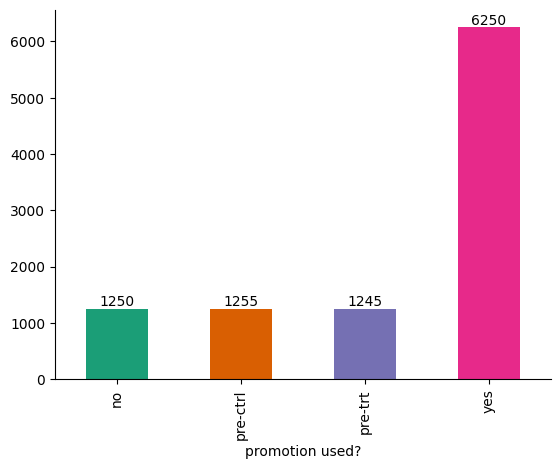

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_unique_rider = df
df_unique_rider = df_unique_rider[df_unique_rider['promotion used?'] != 'pre-exp']

ax = df_unique_rider.groupby('promotion used?').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
ax.bar_label(ax.containers[0])
plt.gca().spines[['top', 'right',]].set_visible(False)


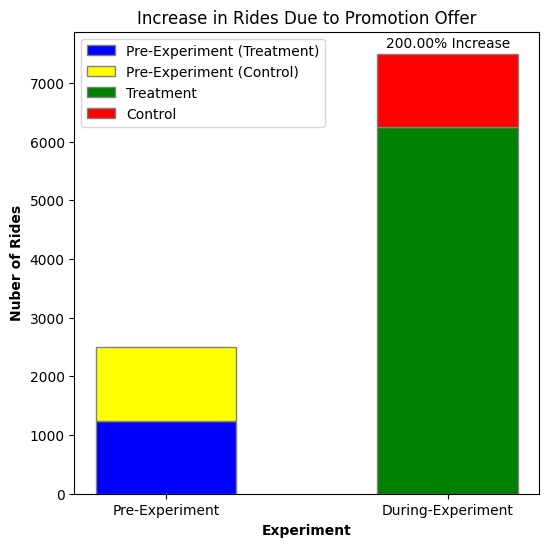

In [ ]:
import matplotlib.pyplot as plt
df_pre_exp = df[df['promotion used?'].isin(['pre-ctrl','pre-trt'])]
df_post_exp = df[~df['promotion used?'].isin(['pre-ctrl','pre-trt'])]

# Calculate the number of rides for each promotion type
num_rides_pre_trt = df_pre_exp[df_pre_exp['promotion used?'] == 'pre-trt'].shape[0]
num_rides_pre_ctrl = df_pre_exp[df_pre_exp['promotion used?'] == 'pre-ctrl'].shape[0]
num_rides_pre_exp = num_rides_pre_trt + num_rides_pre_ctrl
num_rides_post_exp = df_post_exp.shape[0]
num_rides_post_exp_yes = df_post_exp[df_post_exp['promotion used?'] == 'yes'].shape[0]
num_rides_post_exp_no = df_post_exp[df_post_exp['promotion used?'] == 'no'].shape[0]

# Calculate the percentage increase in the number of rides
percent_increase = (num_rides_post_exp - num_rides_pre_exp) / num_rides_pre_exp * 100

# Define the bar width
bar_width = 0.35

# Set the position of the bars on the x-axis
r1,r2 = 0,2*bar_width

# Create a bar chart to visualize the results
fig, ax = plt.subplots(figsize=(6, 6))

plt.bar(r1, [num_rides_pre_trt], color='blue', width=bar_width, edgecolor='grey', label='Pre-Experiment (Treatment)')
plt.bar(r1, [num_rides_pre_ctrl], bottom=[num_rides_pre_trt], color='yellow', width=bar_width, edgecolor='grey', label='Pre-Experiment (Control)')
plt.bar(r2, [num_rides_post_exp_yes], color='green', width=bar_width, edgecolor='grey', label='Treatment')
plt.bar(r2, [num_rides_post_exp_no], bottom=[num_rides_post_exp_yes], color='red', width=bar_width, edgecolor='grey', label='Control')

ax.set_title('Increase in Rides Due to Promotion Offer')

# Add labels
plt.xlabel('Experiment', fontweight='bold')
plt.ylabel('Nuber of Rides', fontweight='bold')
plt.xticks([0, r2], ['Pre-Experiment', 'During-Experiment'])

plt.legend()

# Add a text box to display the percentage increase
ax.text(r2, num_rides_post_exp + 100, f'{percent_increase:.2f}% Increase', ha='center')

plt.show()

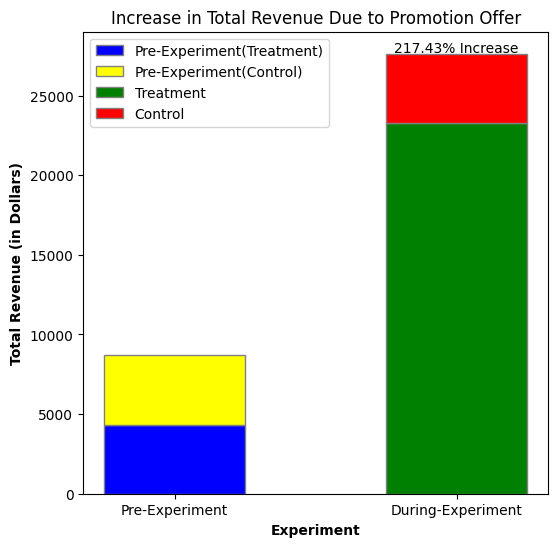

In [ ]:
import matplotlib.pyplot as plt
# Calculate the total revenue for each promotion type
total_revenue_pre_exp_trt = df_pre_exp[df_pre_exp['promotion used?']=='pre-trt']['revenue earned'].sum()
total_revenue_pre_exp_ctrl = df_pre_exp[df_pre_exp['promotion used?']=='pre-ctrl']['revenue earned'].sum()
total_revenue_post_exp_yes = df_post_exp[df_post_exp['promotion used?']=='yes']['revenue earned'].sum()
total_revenue_post_exp_no = df_post_exp[df_post_exp['promotion used?']=='no']['revenue earned'].sum()
total_revenue_pre_exp = total_revenue_pre_exp_trt + total_revenue_pre_exp_ctrl
total_revenue_post_exp = total_revenue_post_exp_yes + total_revenue_post_exp_no

# Calculate the percentage increase in total revenue
percent_increase_revenue = (total_revenue_post_exp - total_revenue_pre_exp) / total_revenue_pre_exp * 100

# Define the bar width
bar_width = 0.35

# Set the position of the bars on the x-axis
r1,r2 = 0,2*bar_width

# Create a bar chart to visualize the results
fig, ax = plt.subplots(figsize=(6, 6))

plt.bar(r1, [total_revenue_pre_exp_trt], color='blue', width=bar_width, edgecolor='grey', label='Pre-Experiment(Treatment)')
plt.bar(r1, [total_revenue_pre_exp_ctrl], bottom=[total_revenue_pre_exp_trt], color='yellow', width=bar_width, edgecolor='grey', label='Pre-Experiment(Control)')
plt.bar(r2, [total_revenue_post_exp_yes], color='green', width=bar_width, edgecolor='grey', label='Treatment')
plt.bar(r2, [total_revenue_post_exp_no], bottom=[total_revenue_post_exp_yes], color='red', width=bar_width, edgecolor='grey', label='Control')

ax.set_title('Increase in Total Revenue Due to Promotion Offer')

# Add labels
plt.xlabel('Experiment', fontweight='bold')
plt.ylabel('Total Revenue (in Dollars)', fontweight='bold')
plt.xticks([0, r2], ['Pre-Experiment', 'During-Experiment'])

plt.legend()

# Add a text box to display the percentage increase
ax.text(r2, total_revenue_post_exp + 100, f'{percent_increase_revenue:.2f}% Increase', ha='center')

plt.show()


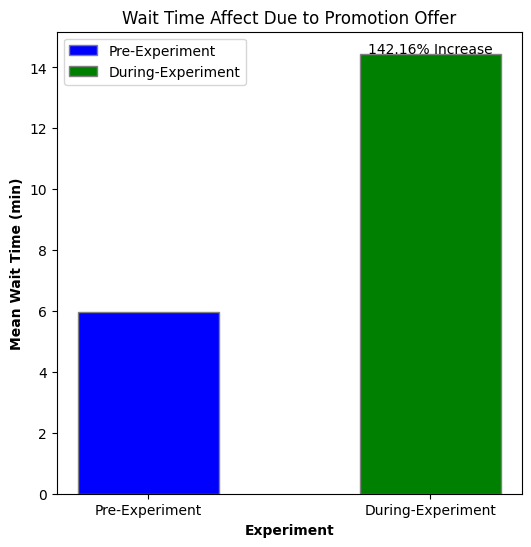

In [ ]:
import matplotlib.pyplot as plt
# Calculate the total revenue for each promotion type
mean_wait_time_pre_exp = df_pre_exp['wait time'].mean()
mean_wait_time_post_exp = df_post_exp['wait time'].mean()

# Calculate the percentage increase in total revenue
percent_increase_revenue = (mean_wait_time_post_exp - mean_wait_time_pre_exp) / mean_wait_time_pre_exp * 100

# Define the bar width
bar_width = 0.35

# Set the position of the bars on the x-axis
r1,r2 = 0,2*bar_width

# Create a bar chart to visualize the results
fig, ax = plt.subplots(figsize=(6, 6))

plt.bar(r1, [mean_wait_time_pre_exp], color='blue', width=bar_width, edgecolor='grey', label='Pre-Experiment')
plt.bar(r2, [mean_wait_time_post_exp], color='green', width=bar_width, edgecolor='grey', label='During-Experiment')

ax.set_title('Wait Time Affect Due to Promotion Offer')

# Add labels
plt.xlabel('Experiment', fontweight='bold')
plt.ylabel('Mean Wait Time (min)', fontweight='bold')
plt.xticks([0, r2], ['Pre-Experiment', 'During-Experiment'])

plt.legend()

# Add a text box to display the percentage increase
ax.text(r2, mean_wait_time_post_exp, f'{percent_increase_revenue:.2f}% Increase', ha='center')

plt.show()
